In [1]:
import os
import cv2
import numpy as np
import glob
from PIL import Image, ImageEnhance
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from utils import *
from copy import deepcopy
plt.rcParams['figure.figsize'] = [18, 9]
plt.rcParams['font.size'] = 16
from skimage.io import imread
from skimage import data, io, img_as_float, exposure
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import nd2
import tifffile
pio.renderers.default='notebook'

In [2]:
PATH = "21-07-2022 chow wt snap23 syntx4 glut4/"
file_name = "stnx4 sysy ins 016.nd2"
#im = imread(os.path.join(PATH, file_name), plugin="tifffile")
im = nd2.imread(os.path.join(PATH, file_name))
im = np.rollaxis(im, 0,3)

In [3]:
size = im.shape[1]
n_channels = im.shape[2]

In [4]:
channel_images = process_channels(im, file_name, clip_limit=0.03)

# Mask extraction

[[20 20 11 ... 20 20 20]
 [20 20 20 ... 11 11 11]
 [11 20 11 ... 11 20 11]
 ...
 [20 20 20 ... 11 11 11]
 [20 20 20 ... 20 11 20]
 [11 11 20 ... 11 11 11]]
[[20 20 11 ... 11 11 11]
 [11 11 11 ... 20 20 11]
 [20 11 20 ... 20 11 11]
 ...
 [20 20 20 ... 20 11 20]
 [11 20 11 ... 11 11 20]
 [11 20 20 ... 11 20 11]]



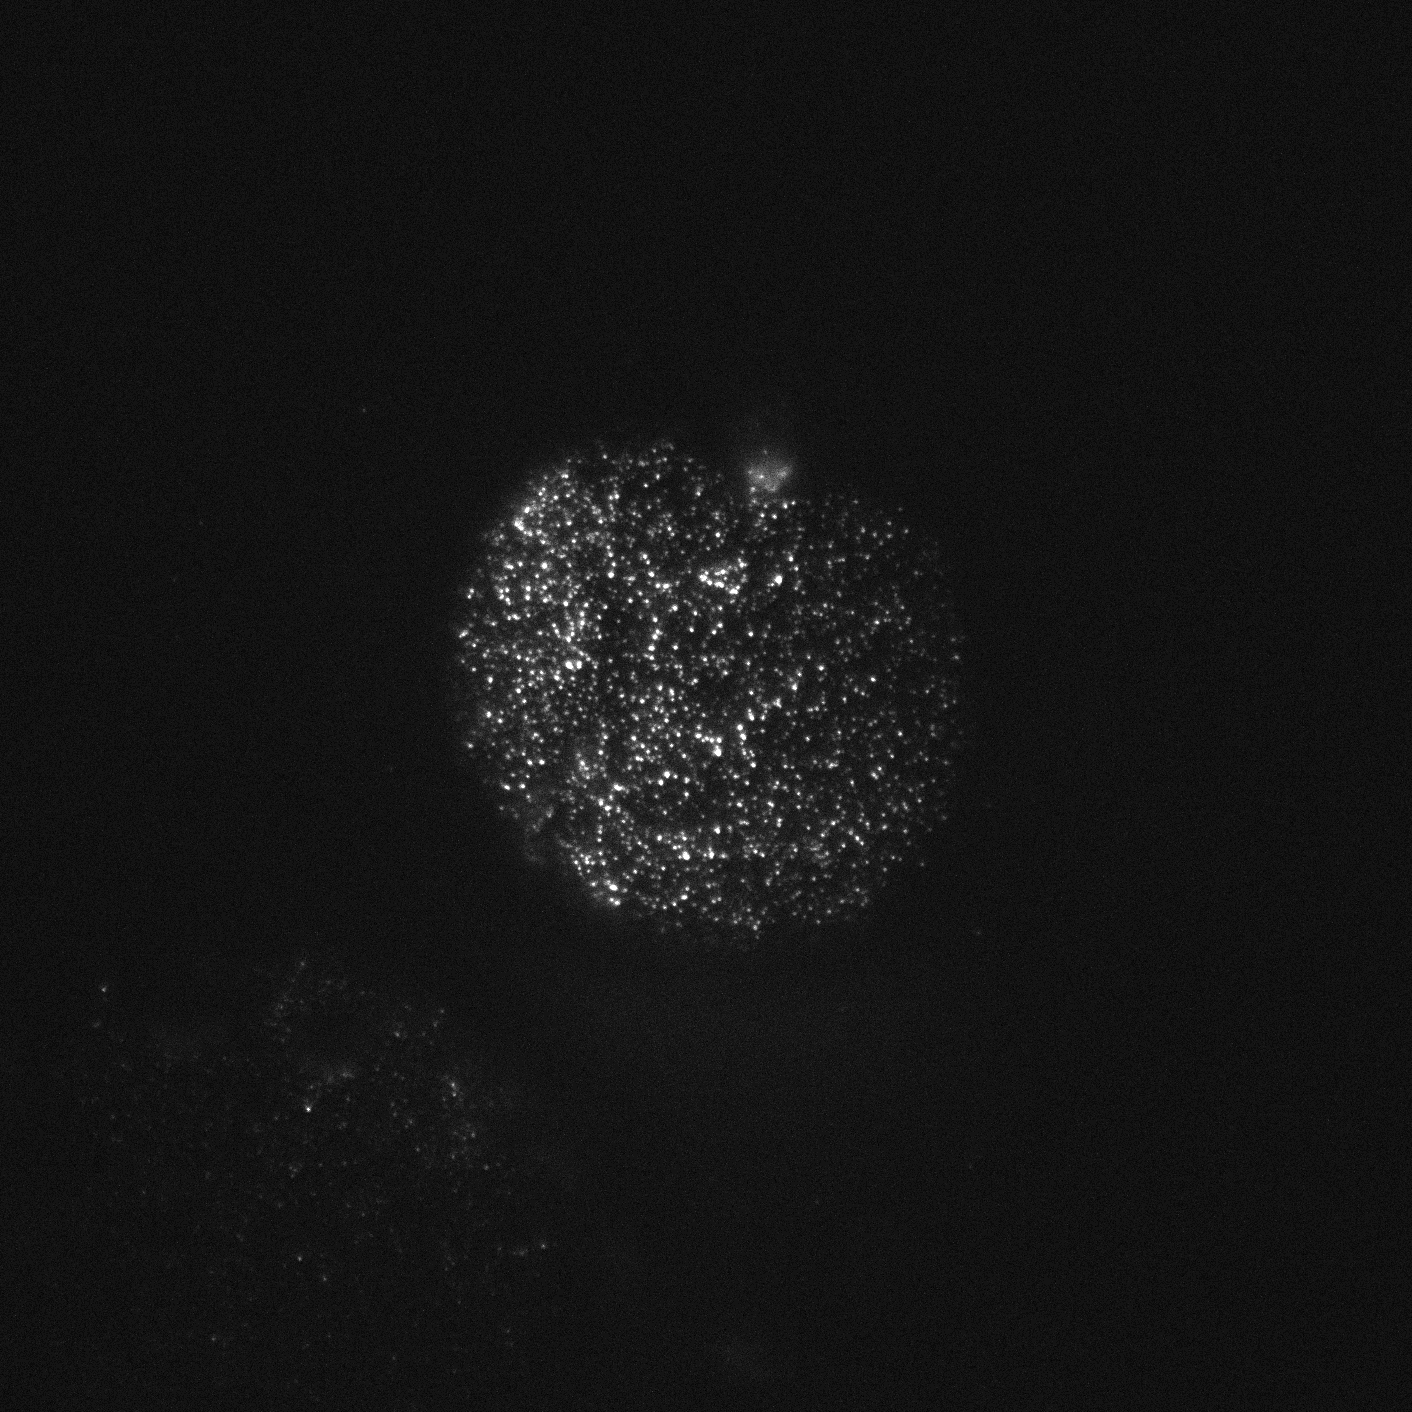
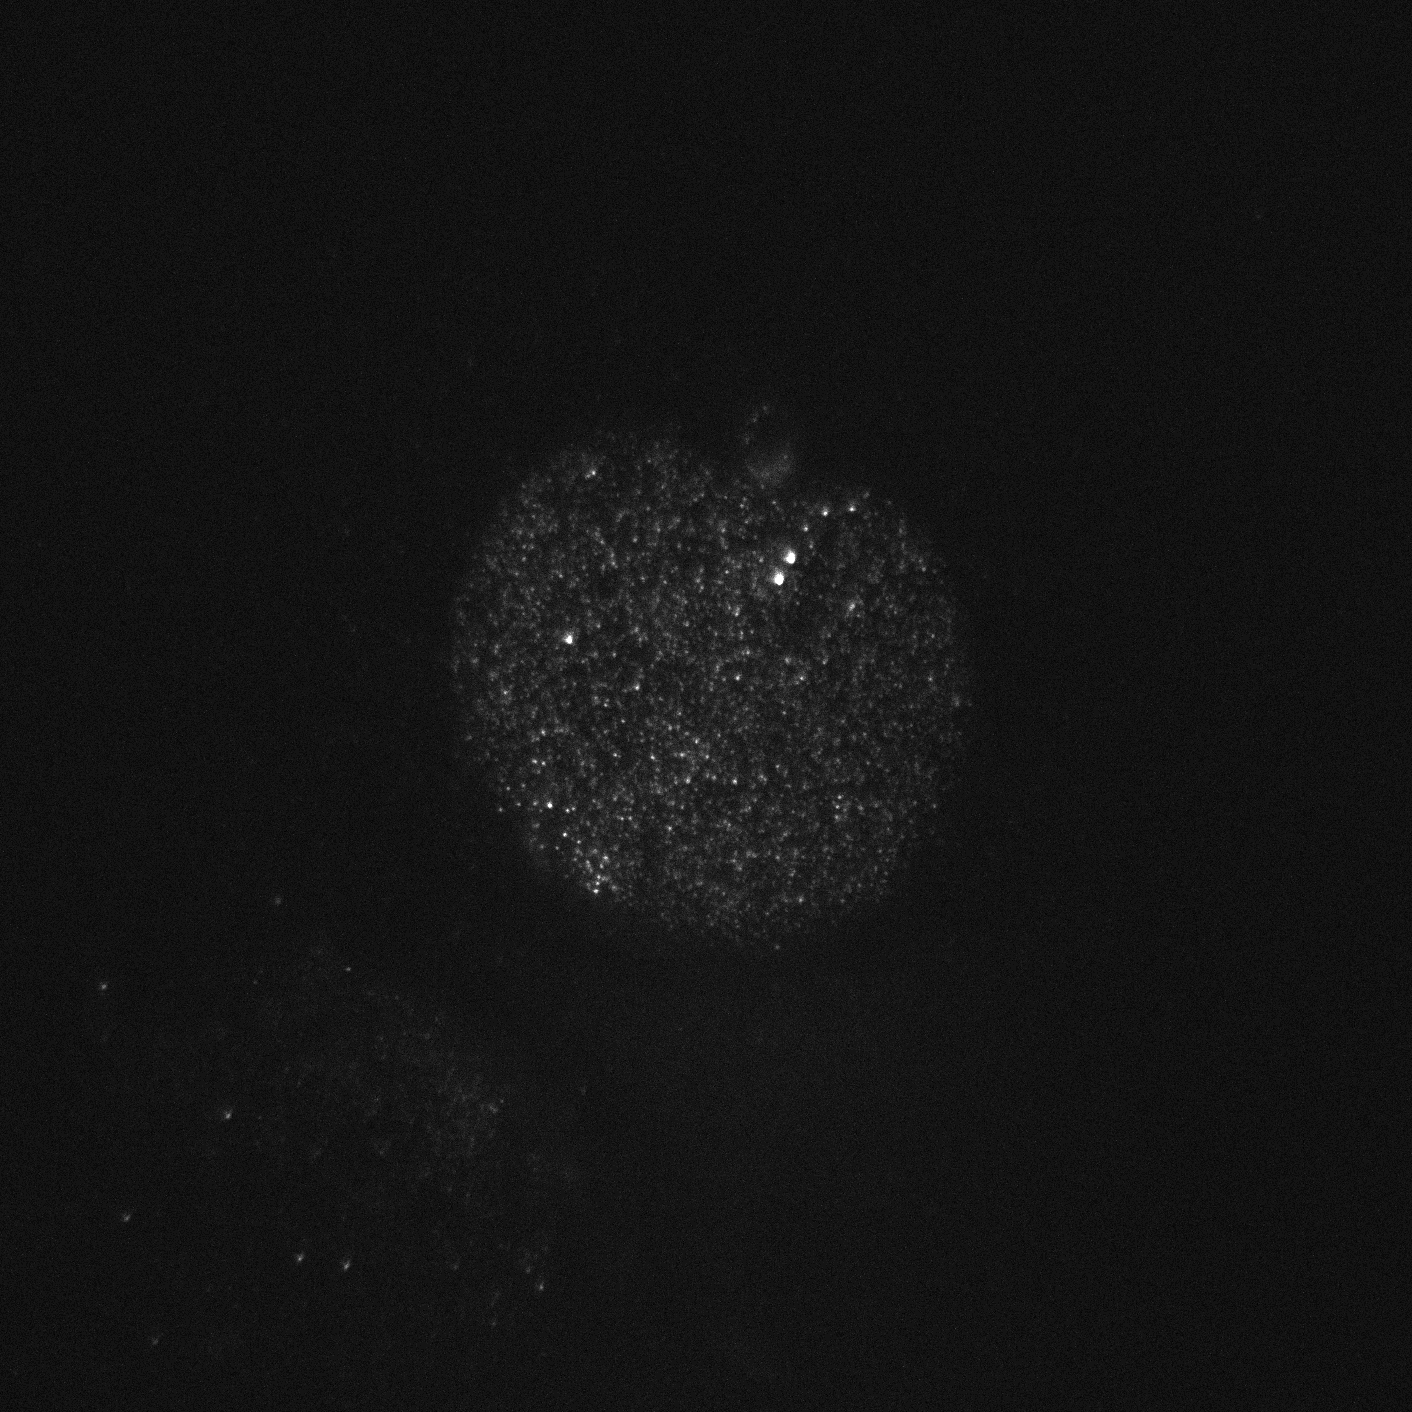

In [8]:
sensitivities = [190 for i in range(n_channels)]

channel_names = [f"Channel {i+1}" for i in range(n_channels)]

detections = {}
for i in channel_names:
        detections[i] = 0
        
fig = make_subplots(rows=1,cols=n_channels, shared_xaxes="all", 
                    shared_yaxes="all",
                    subplot_titles = (channel_names))


df_RGB = pd.DataFrame(columns = ["File", "Channel", "#", "Intensity", "AreaPx", "type"])

for j, image in enumerate(channel_images):
    colors = ["#00FF00", "#FF00FF", "#00BFFF"]

    ch_image = px.imshow(image,
                         color_continuous_scale='gray',
                         binary_string=True, binary_backend="jpg")

    fig = fig.add_trace(ch_image.data[0],
                       row=1, col=j+1)

    fig.update_layout(coloraxis_showscale=False)
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)

    mask, contours, hierarchy = extract_masks(image, sensitivities[j], dilation=False)
    detections[channel_names[j]] = len(contours)
    
    for i in range(len(contours)):

        contour_im = cv2.drawContours(deepcopy(mask) , contours, i, (255,0,0),-1, hierarchy=hierarchy, maxLevel = 0)

        contour_idx = np.where(contour_im.flatten()<250)
        noncontour_idx = np.where(contour_im.flatten()>250)

        cropped_mask = deepcopy(image.reshape(-1))
        cropped_mask[contour_idx] = 0 

        intensity = int(np.round(np.mean(cropped_mask[noncontour_idx])))
        area_px = len(cropped_mask[noncontour_idx])
        area_si = 'X'
        
        new_entry = pd.DataFrame(
            {"File" : pd.Series(file_name, dtype="string"),
             "Channel" : pd.Series(j, dtype="int"),
            "#": pd.Series(i, dtype="int"),
            "Intensity": pd.Series(intensity, dtype="int"),
            "AreaPx": pd.Series(area_px, dtype="int"),
            "type": pd.Series(file_name.split(" ")[2], dtype="string")})
        
        df_RGB = pd.concat([df_RGB, new_entry], ignore_index=True)

        cropped_mask = cropped_mask.reshape(size,size)

        x_con = contours[i].reshape(contours[i].shape[0],-1)[:,0]
        y_con = contours[i].reshape(contours[i].shape[0],-1)[:,1]
        hoverinfo = f"Intensity: {intensity}/255<br>Area: {area_px} px | {area_si} μm²"
        fig.add_scatter(x=x_con, y=y_con, 
                        mode="lines",
                        fill="toself",
                        line=dict(color=colors[j]),
                        showlegend=False,
                        hovertemplate=hoverinfo,
                        hoveron="points+fills",
                        name=f"#{i+1}",
                        row=1, col=j+1
                       )
    fig.layout.annotations[j].update(y=0.9)
fig.for_each_annotation(lambda a: a.update(text = a.text + "    #Detections: "+str(detections[a.text])))
fig['layout'].update(height=image.shape[1]*0.8, 
                     width=image.shape[1]*1.7)

fig.show()


if not os.path.exists(os.path.join("results", file_name)):
    os.mkdir(os.path.join("results", file_name))


df_RGB.to_csv(f"results/{file_name}/info.csv")
fig.write_html(f"results/{file_name}/detections.html")



In [9]:
import plotly.graph_objects as go
import plotly.express as px
pio.renderers.default='svg'
def create_RGBboxplot(df_RGB, column):
    
    fig = px.box(df_RGB, x="Channel", y=column, color="File")
    fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
    fig.show()
    
    if not os.path.exists("statistics"):
        os.mkdir("statistics")
    fig.write_html(f"statistics/boxplot_{column}.html")
    fig.write_image(f"statistics/boxplot_{column}.svg")
    fig.write_image(f"statistics/boxplot_{column}.pdf")

    return fig

def create_RGBboxplot_overall(df_RGB, column):
    
    fig = px.box(df_RGB, x="Channel", y=column, color="type")
    fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
    fig.show()
    
    if not os.path.exists("statistics_overall"):
        os.mkdir("statistics_overall")
    fig.write_html(f"statistics_overall/boxplot_{column}.html")
    fig.write_image(f"statistics_overall/boxplot_{column}.svg")
    fig.write_image(f"statistics_overall/boxplot_{column}.pdf")

    return fig

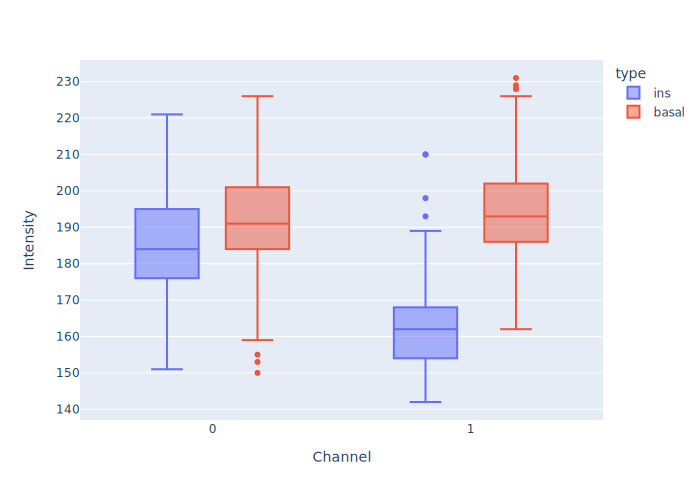

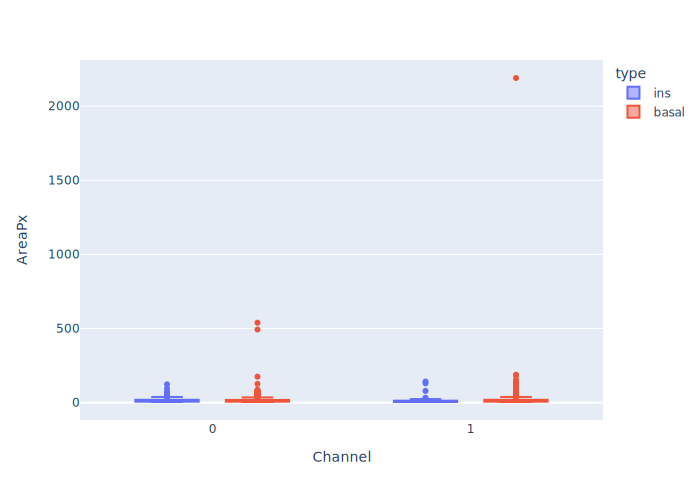

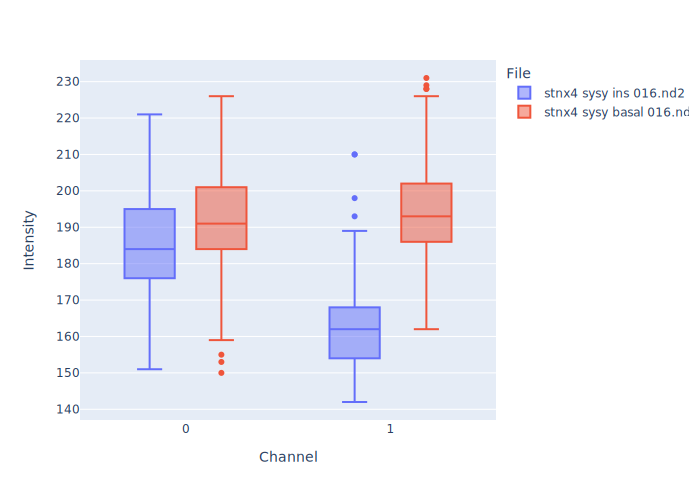

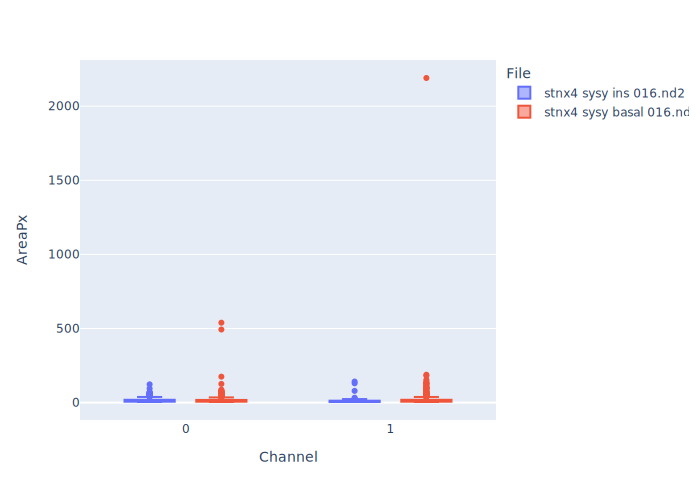

In [89]:

def compute_statistics(images_names):
    
    df_RGB = pd.DataFrame(columns = ["File", "Channel", "#", "Intensity", "AreaPx"])

    for image_name in images_names:
        df_RGB = pd.concat([df_RGB, pd.read_csv(os.path.join("results", image_name, "info.csv"))], ignore_index=True)
    
    create_RGBboxplot_overall(df_RGB, "Intensity")
    create_RGBboxplot_overall(df_RGB, "AreaPx")
    
    create_RGBboxplot(df_RGB, "Intensity")
    create_RGBboxplot(df_RGB, "AreaPx")
                         
        
images_list = ['stnx4 sysy ins 016.nd2', 'stnx4 sysy basal 016.nd2']#, "nextimage", "nextimage2"]
compute_statistics(images_list)